# ADS 509 Module 3: Group Comparison 

The task of comparing two groups of text is fundamental to textual analysis. There are innumerable applications: survey respondents from different segments of customers, speeches by different political parties, words used in Tweets by different constituencies, etc. In this assignment you will build code to effect comparisons between groups of text data, using the ideas learned in reading and lecture.

This assignment asks you to analyze the lyrics and Twitter descriptions for the two artists you selected in Module 1. If the results from that pull were not to your liking, you are welcome to use the zipped data from the “Assignment Materials” section. Specifically, you are asked to do the following: 

* Read in the data, normalize the text, and tokenize it. When you tokenize your Twitter descriptions, keep hashtags and emojis in your token set. 
* Calculate descriptive statistics on the two sets of lyrics and compare the results. 
* For each of the four corpora, find the words that are unique to that corpus. 
* Build word clouds for all four corpora. 

Each one of the analyses has a section dedicated to it below. Before beginning the analysis there is a section for you to read in the data and do your cleaning (tokenization and normalization). 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
import os
import re
import emoji
import pandas as pd

from collections import Counter, defaultdict
from nltk.corpus import stopwords
from string import punctuation
from wordcloud import WordCloud 

from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer


In [2]:
# Use this space for any additional import statements you need



In [3]:
# Place any addtional functions or constants you need here. 

# Some punctuation variations
punctuation = set(punctuation) # speeds up comparison
tw_punct = punctuation - {"#"}

# Stopwords
sw = stopwords.words("english")

# Two useful regex
whitespace_pattern = re.compile(r"\s+")
hashtag_pattern = re.compile(r"^#[0-9a-zA-Z]+")

# It's handy to have a full set of emojis
all_language_emojis = set()

for country in emoji.EMOJI_DATA : 
    for em in emoji.EMOJI_DATA[country] : 
        all_language_emojis.add(em)

# and now our functions
def descriptive_stats(tokens, num_tokens = 5, verbose=True) :
    """
        Given a list of tokens, print number of tokens, number of unique tokens, 
        number of characters, lexical diversity, and num_tokens most common
        tokens. Return a list of 
    """

    num_tokens = len(tokens)
    num_unique_tokens = len(set(tokens))
    lexical_diversity = num_unique_tokens/num_tokens
    num_characters = sum(len(token) for token in tokens)
    
    
    if verbose :        
        print(f"There are {num_tokens} tokens in the data.")
        print(f"There are {num_unique_tokens} unique tokens in the data.")
        print(f"There are {num_characters} characters in the data.")
        print(f"The lexical diversity is {lexical_diversity:.3f} in the data.")
    
        # print the five most common tokens
        
    return([num_tokens, num_unique_tokens,
            lexical_diversity,
            num_characters])
    


def contains_emoji(s):
    
    s = str(s)
    emojis = [ch for ch in s if emoji.is_emoji(ch)]

    return(len(emojis) > 0)


def remove_stop(tokens) :
    return[t for t in tokens if t not in sw]

 
def remove_punctuation(text, punct_set=tw_punct) : 
    return("".join([ch for ch in text if ch not in punct_set]))

def tokenize(text) : 
    """ Splitting on whitespace rather than the book's tokenize function. That 
        function will drop tokens like '#hashtag' or '2A', which we need for Twitter. """
    
    return([item.lower() for item in whitespace_pattern.split(text)])

pipeline = [str.lower, tokenize, remove_punctuation, remove_stop]

def prepare(text, pipeline) : 
    tokens = str(text)
    
    for transform in pipeline : 
        tokens = transform(tokens)
        
    return(tokens)


## Data Ingestion

Use this section to ingest your data into the data structures you plan to use. Typically this will be a dictionary or a pandas DataFrame.

In [4]:
#Set up for Twitter Data

data_location = "/Users/jackieurenda/Desktop/ADS 509/" 
twitter_folder = "twitter/"
lyrics_folder = "lyrics/"

artist_files = {'cher':'cher_followers_data.txt',
                'robyn':'robynkonichiwa_followers_data.txt'}


In [5]:
twitter_data = pd.read_csv(data_location + twitter_folder + artist_files['cher'],
                           sep="\t",
                           quoting=3)

twitter_data['artist'] = "cher"

In [6]:
twitter_data_2 = pd.read_csv(data_location + twitter_folder + artist_files['robyn'],
                             sep="\t",
                             quoting=3)
twitter_data_2['artist'] = "robyn"

twitter_data = pd.concat([
    twitter_data,twitter_data_2])
    
del(twitter_data_2)

In [7]:
twitter_data.head()

,screen_name,name,id,location,followers_count,friends_count,description,artist
0,hsmcnp,Country Girl,35152213,NaN,1302,1014,NaN,cher
1,horrormomy,Jeny,742153090850164742,Earth,81,514,𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜,cher
2,anju79990584,anju,1496463006451974150,NaN,13,140,163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡,cher
3,gallionjenna,J,3366479914,NaN,752,556,csu,cher
4,bcscomm,bcscomm,83915043,"Washington, DC",888,2891,Writer @Washinformer @SpelmanCollege alumna #D...,cher


In [8]:
cher_folder = os.listdir(data_location + lyrics_folder + 'cher/')
cher_files = [LF for LF in cher_folder]


lyrics_data = defaultdict(list)
for LF in cher_files :
    artist = LF.split("_")[0]
    song = LF.split("_")[1]    
    song = song.split(".")[0]
    with open(data_location + lyrics_folder + 'cher/' + LF,'r', encoding='utf8') as infile :
        
        lyrics_data[artist].append(infile.read())


In [9]:
robyn_folder = os.listdir(data_location + lyrics_folder + 'robyn/')
robyn_files = [LF for LF in robyn_folder]

for LF in robyn_files :
    artist = LF.split("_")[0]
    song = LF.split("_")[1]    
    song = song.split(".")[0]


    with open(data_location + lyrics_folder + 'robyn/' + LF,'r', encoding='utf8') as infile :
        
        lyrics_data[artist].append(infile.read())


In [10]:
lyrics_data = pd.DataFrame (list (lyrics_data.items ()),columns = ['artist','lyrics'])
lyrics_data.head()

,artist,lyrics
0,cher,"[""Come And Stay With Me""\n\n\n\nI'll send away..."
1,robyn,"[""Include Me Out""\n\n\n\nIt is really very sim..."


In [15]:
for col in lyrics_data.columns:
    print(col)

artist
lyrics


## Tokenization and Normalization

In this next section, tokenize and normalize your data. We recommend the following cleaning. 

**Lyrics** 

* Remove song titles
* Casefold to lowercase
* Remove stopwords (optional)
* Remove punctuation
* Split on whitespace

Removal of stopwords is up to you. Your descriptive statistic comparison will be different if you include stopwords, though TF-IDF should still find interesting features for you. Note that we remove stopwords before removing punctuation because the stopword set includes punctuation.

**Twitter Descriptions** 

* Casefold to lowercase
* Remove stopwords
* Remove punctuation other than emojis or hashtags
* Split on whitespace

Removing stopwords seems sensible for the Twitter description data. Remember to leave in emojis and hashtags, since you analyze those. 

In [12]:
# apply the `pipeline` techniques from BTAP Ch 1 or 5

my_pipeline = [str.lower, remove_punctuation, tokenize, remove_stop]

lyrics_data["tokens"] = lyrics_data["lyrics"].apply(prepare,pipeline=my_pipeline)
lyrics_data["num_tokens"] = lyrics_data["tokens"].map(len) 

twitter_data["tokens"] = twitter_data["description"].apply(prepare,pipeline=my_pipeline)
twitter_data["num_tokens"] = twitter_data["tokens"].map(len) 


In [13]:
twitter_data['has_emoji'] = twitter_data["description"].apply(contains_emoji)

Let's take a quick look at some descriptions with emojis.

In [14]:
twitter_data[twitter_data.has_emoji].sample(10)[["artist","description","tokens"]]

,artist,description,tokens
1740494,cher,"Hi! I'm Corrinna. I am a wife,a mom, a fur mom...","[hi, im, corrinna, wifea, mom, fur, mom, repti..."
2781503,cher,one direction ❤️️,"[one, direction, ❤️️]"
157242,cher,22 Year Old Artist 💁🏽 Self Taught Artist ✏️ Fi...,"[22, year, old, artist, 💁🏽, self, taught, arti..."
1252153,cher,🎻🎶🦋🍀,[🎻🎶🦋🍀]
249700,cher,🏳️‍🌈 democratic socialist. registered nurse. r...,"[🏳️‍🌈, democratic, socialist, registered, nurs..."
986531,cher,Momma. Wife. CrossFit. Harry Potter. ✌️✌️✌️,"[momma, wife, crossfit, harry, potter, ✌️✌️✌️]"
217657,cher,"I like girly & nerdy shit, Miami sports, video...","[like, girly, nerdy, shit, miami, sports, vide..."
103422,cher,"🇧🇷🚩🏳Esquerdista, contra destruição de direitos...","[🇧🇷🚩🏳esquerdista, contra, destruição, de, dire..."
169278,cher,c-section on Friday the 13th | 3L | abolitioni...,"[csection, friday, 13th, 3l, abolitionist, soc..."
791026,cher,@UniversalConnection 🌍 U.C Records Yung!MC!Pro...,"[universalconnection, 🌍, uc, records, yungmcpr..."


With the data processed, we can now start work on the assignment questions. 

Q: What is one area of improvement to your tokenization that you could theoretically carry out? (No need to actually do it; let's not make perfect the enemy of good enough.)

A: I think based on the sample results I saw within the Twitter data, there's a lot of room for improvement. The pipleline was effective in removing unecessary characters and stop words to extract meaninful information, however there were some descriptions that are in different languages. I have read different articles of how data can be processed for multiple langauges, however it can be challenging especially if there are more than 2. Anotherr thing that could be carried out is the removal of nulls- I didn't include this step. 

## Calculate descriptive statistics on the two sets of lyrics and compare the results. 


In [15]:
# your code here
artist = ['cher', 'robyn']

for artist in artist:
    lyric_tokens = [token for sublist in lyrics_data[lyrics_data['artist']==artist]['tokens']
               for token in sublist]
    
    print(f'\n {artist} lyrics descriptive statistics:')
    print(descriptive_stats(lyric_tokens))




 cher lyrics descriptive statistics:
There are 34926 tokens in the data.
There are 9879 unique tokens in the data.
There are 212782 characters in the data.
The lexical diversity is 0.283 in the data.
[34926, 9879, 0.28285517952241884, 212782]

 robyn lyrics descriptive statistics:
There are 14483 tokens in the data.
There are 4044 unique tokens in the data.
There are 90031 characters in the data.
The lexical diversity is 0.279 in the data.
[14483, 4044, 0.2792239176966098, 90031]


Q: what observations do you make about these data? 

A: The cher lyrics data has more tokens and unique tokens, showing there's more variety of words within the cher lyrics compared to the robyn lyrivs. Despite robyn lyrics having less tokens and unique tokens, robyn's lyric lexical diversity is pretty close to cher's lyrics lexical diversity. 


## Find tokens uniquely related to a corpus

Typically we would use TF-IDF to find unique tokens in documents. Unfortunately, we either have too few documents (if we view each data source as a single document) or too many (if we view each description as a separate document). In the latter case, our problem will be that descriptions tend to be short, so our matrix would be too sparse to support analysis. 

To avoid these problems, we will create a custom statistic to identify words that are uniquely related to each corpus. The idea is to find words that occur often in one corpus and infrequently in the other(s). Since corpora can be of different lengths, we will focus on the _concentration_ of tokens within a corpus. "Concentration" is simply the count of the token divided by the total corpus length. For instance, if a corpus had length 100,000 and a word appeared 1,000 times, then the concentration would be $\frac{1000}{100000} = 0.01$. If the same token had a concentration of $0.005$ in another corpus, then the concentration ratio would be $\frac{0.01}{0.005} = 2$. Very rare words can easily create infinite ratios, so you will also add a cutoff to your code so that a token must appear at least $n$ times for you to return it. 

An example of these calculations can be found in [this spreadsheet](https://docs.google.com/spreadsheets/d/1P87fkyslJhqXFnfYezNYrDrXp_GS8gwSATsZymv-9ms). Please don't hesitate to ask questions if this is confusing. 

In this section find 10 tokens for each of your four corpora that meet the following criteria: 

1. The token appears at least `n` times in all corpora
1. The tokens are in the top 10 for the highest ratio of appearances in a given corpora vs appearances in other corpora.

You will choose a cutoff for yourself based on the side of the corpus you're working with. If you're working with the Robyn-Cher corpora provided, `n=5` seems to perform reasonably well.

In [16]:
# your code here



,screen_name,name,id,location,followers_count,friends_count,description,artist,tokens,num_tokens,has_emoji
0,hsmcnp,Country Girl,35152213,NaN,1302,1014,NaN,cher,[nan],1,False
1,horrormomy,Jeny,742153090850164742,Earth,81,514,𝙿𝚛𝚘𝚞𝚍 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛 𝚘𝚏 𝚖𝚎𝚜𝚜𝚢 𝚋𝚞𝚗𝚜 & 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜,cher,"[𝙿𝚛𝚘𝚞𝚍, 𝚜𝚞𝚙𝚙𝚘𝚛𝚝𝚎𝚛, 𝚘𝚏, 𝚖𝚎𝚜𝚜𝚢, 𝚋𝚞𝚗𝚜, 𝚕𝚎𝚐𝚐𝚒𝚗𝚐𝚜]",6,False
2,anju79990584,anju,1496463006451974150,NaN,13,140,163㎝／愛かっぷ💜26歳🍒 工〇好きな女の子💓 フォローしてくれたらDMします🧡,cher,"[163㎝／愛かっぷ💜26歳🍒, 工〇好きな女の子💓, フォローしてくれたらdmします🧡]",3,True
3,gallionjenna,J,3366479914,NaN,752,556,csu,cher,[csu],1,False
4,bcscomm,bcscomm,83915043,"Washington, DC",888,2891,Writer @Washinformer @SpelmanCollege alumna #D...,cher,"[writer, washinformer, spelmancollege, alumna,...",17,False


Q: What are some observations about the top tokens? Do you notice any interesting items on the list? 

A: 

## Build word clouds for all four corpora. 

For building wordclouds, we'll follow exactly the code of the text. The code in this section can be found [here](https://github.com/blueprints-for-text-analytics-python/blueprints-text/blob/master/ch01/First_Insights.ipynb). If you haven't already, you should absolutely clone the repository that accompanies the book. 


In [16]:
from matplotlib import pyplot as plt

def wordcloud(word_freq, title=None, max_words=200, stopwords=None):

    wc = WordCloud(width=800, height=400, 
                   background_color= "black", colormap="Paired", 
                   max_font_size=150, max_words=max_words)
    
    # convert data frame into dict
    if type(word_freq) == pd.Series:
        counter = Counter(word_freq.fillna(0).to_dict())
    else:
        counter = word_freq

    # filter stop words in frequency counter
    if stopwords is not None:
        counter = {token:freq for (token, freq) in counter.items() 
                              if token not in stopwords}
    wc.generate_from_frequencies(counter)
 
    plt.title(title) 

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")
    
    
def count_words(df, column='tokens', preprocess=None, min_freq=2):

    # process tokens and update counter
    def update(doc):
        tokens = doc if preprocess is None else preprocess(doc)
        counter.update(tokens)

    # create counter and run through all data
    counter = Counter()
    df[column].map(update)

    # transform counter into data frame
    freq_df = pd.DataFrame.from_dict(counter, orient='index', columns=['freq'])
    freq_df = freq_df.query('freq >= @min_freq')
    freq_df.index.name = 'token'
    
    return freq_df.sort_values('freq', ascending=False)

In [17]:
#removing null values from both dataframes:
twitter_data = twitter_data.dropna()
lyrics_data = lyrics_data.dropna()

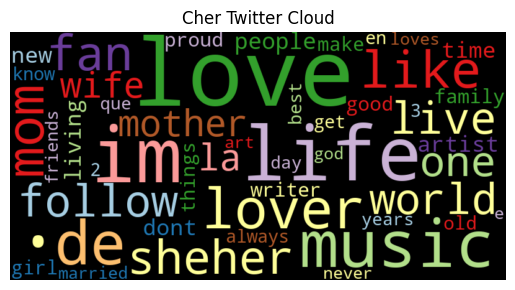

In [18]:
cher_twitter = twitter_data[twitter_data['artist'] == 'cher']
word_freq = count_words(cher_twitter, column='tokens', min_freq=5)
wordcloud(word_freq['freq'], title='Cher Twitter Cloud', max_words=50)
plt.show()

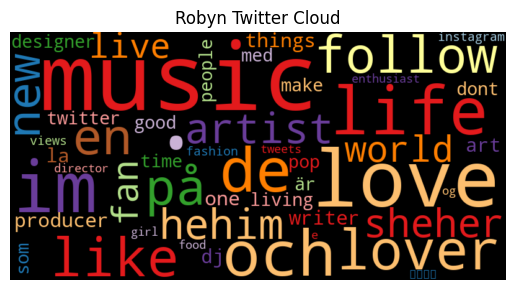

In [19]:
robyn_twitter = twitter_data[twitter_data['artist'] == 'robyn']
word_freq = count_words(robyn_twitter, column='tokens', min_freq=5)
wordcloud(word_freq['freq'], title='Robyn Twitter Cloud', max_words=50)
plt.show()

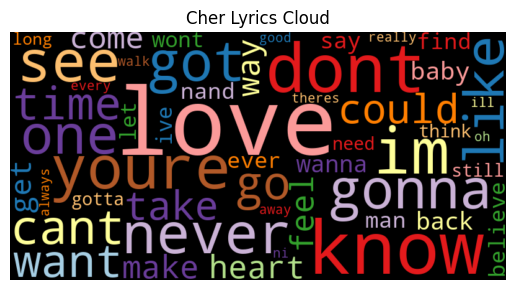

In [22]:
cher_lyrics = lyrics_data[lyrics_data['artist'] == 'cher']
word_freq = count_words(cher_lyrics, column='tokens', min_freq=5)
wordcloud(word_freq['freq'], title='Cher Lyrics Cloud', max_words=50)
plt.show()

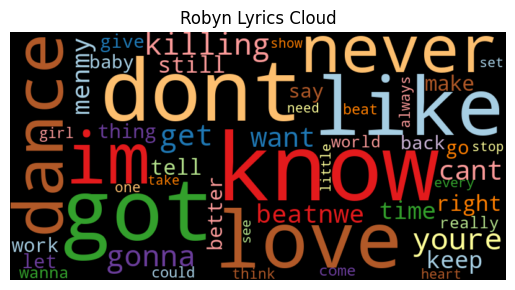

In [23]:
robyn_lyrics = lyrics_data[lyrics_data['artist'] == 'robyn']
word_freq = count_words(robyn_lyrics, column='tokens', min_freq=5)
wordcloud(word_freq['freq'], title='Robyn Lyrics Cloud', max_words=50)
plt.show()

Q: What observations do you have about these (relatively straightforward) wordclouds? 

A: An observation I made based on these wordclouds is that cher and robyn have similar words to each other in the Twiter data such as "music", "love" and "life". There's a pretty common "theme" between both artist's Twitter data based on these wordclouds. The lyrics wordclouds seems to have more diversity of words- showing that the different artists lyrical subjects vary. For example, a word in cher's wordcloud is "man", which doesn't seem to be a prominent word in Robyn's lyrics. Similarly, the word "killing" is in Robyn's wordcloud, which doesn't appear in Cher's.